In [1]:
%pylab inline
from scipy.integrate import solve_ivp
from IPython import display
import time
import scipy.integrate as integrate
from scipy.optimize import curve_fit

Populating the interactive namespace from numpy and matplotlib


### Initializations

In [19]:
# the 1D space
length = 30.0
Lmax = length
Lmin = -length
dx = 0.1
Nx = int((Lmax-Lmin)/dx) +1
xs = linspace(Lmin, Lmax, Nx)

# will be used to determine atot (atot = N) when only D is specified  
# and used to determine D (D = atot/N) when only atot is specified
N = 100.0 

# the diffusion coefficients
Ds = logspace(-3,-1,15,base=10)
D_n = len(Ds)

nu = 0.5 # raw burn rate

dt = 0.001
tf = 100.0 #each run goes for (tf/dt) steps 
run_n = 30 # number of runs

print(Ds)

[0.001      0.0013895  0.0019307  0.0026827  0.00372759 0.00517947
 0.00719686 0.01       0.01389495 0.01930698 0.02682696 0.03727594
 0.05179475 0.07196857 0.1       ]


### Unbiased initial substrate 
#### efficiency vs. D (a0 = 1/sigma)

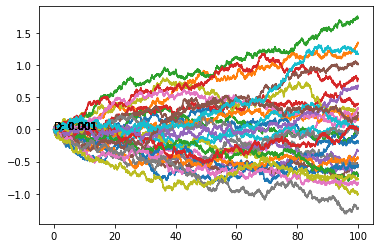

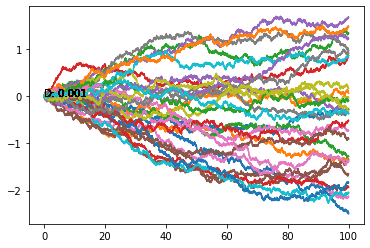

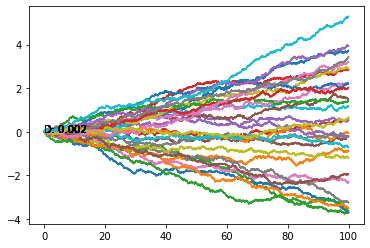

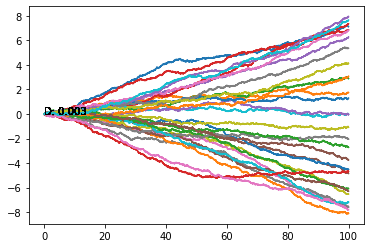

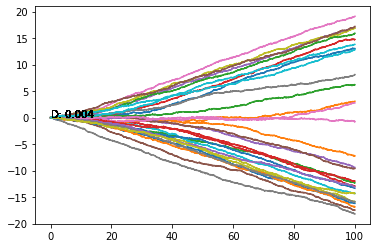

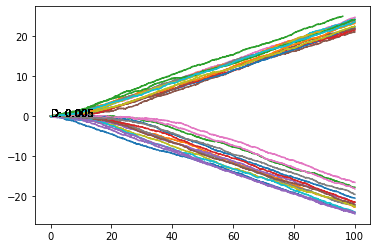

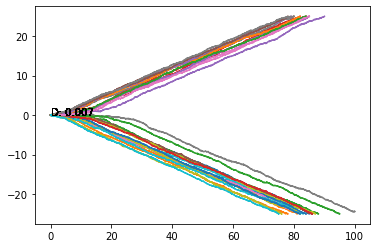

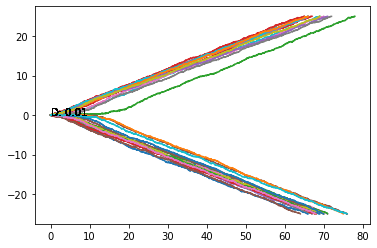

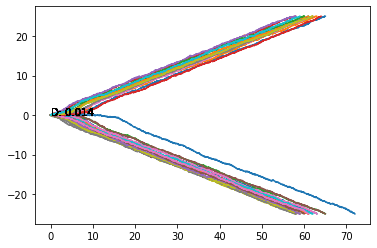

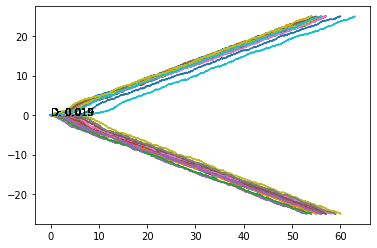

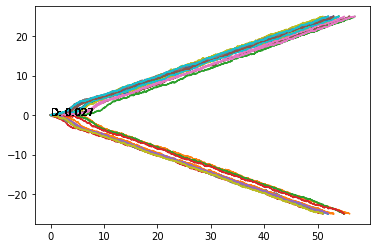

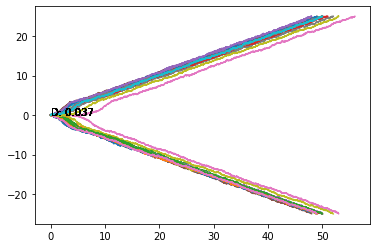

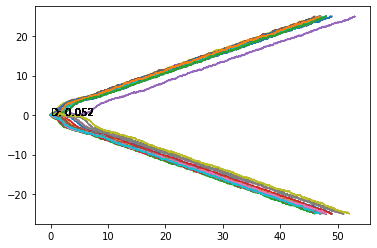

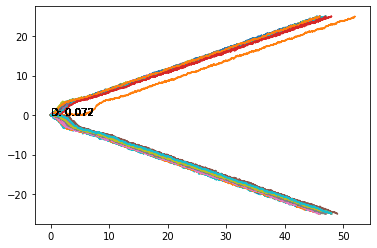

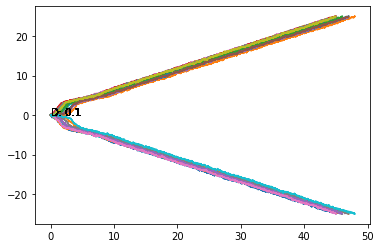

In [20]:

sol_0D = []
for D in Ds: 
    sol_1 = []
    for run in range(run_n):
        xp = 0.0
        Ac = zeros(Nx) #initialize bound complex
        
        #intialize substrate
        As = zeros(Nx) 
        As[xs > 2.0] = N # here atot = N
        As[xs < -2.0] = N

        # some values to save for each time step
        xp_t = [] # position
        v_t = [] # times
        burn_t = [] # burn rate
        
        noisescale = sqrt(2*dt*D) # the scale of diffusion
        t_max = int(tf/dt)
        for t in range(t_max): 
            
            total_f = D * trapz(-(xp -xs) * Ac, x=xs)
            binding = exp(-0.5 * (xp - xs) ** 2) * As
            burnt = nu * Ac
            Ac += (binding - burnt) *dt
            As += (- binding) * dt
            noise = noisescale* random.normal(0.0,1.0)
            
            xp += total_f * dt + noise # update position

            if t % 10.0 == 0.0: # save values
                xp_t.append(xp)
                v_t.append(total_f+noise/dt)
                burn_t.append(trapz(Ac*nu,x=xs))
    
            if abs(xp) > length -5.0: # stop before it hits an edge
                break
                
        
        plot(linspace(0,int((t+1)*dt),int(t/10+1)),xp_t)
        text(0.0,0.0,"D: "+str(round(D,3)))
        
        
        # save the mean velocity and burn rate for the last 90% of the run
        sol_1.append([xp_t[-2000:],burn_t[-2000:]])
    show()
    # save these for each diffusion coefficient
    sol_0D.append(sol_1)
display.clear_output(wait=True)

### Biased initial substrate 
#### efficiency vs. D (a0 = 1/sigma)

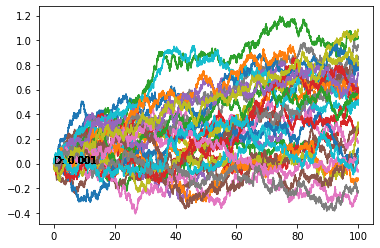

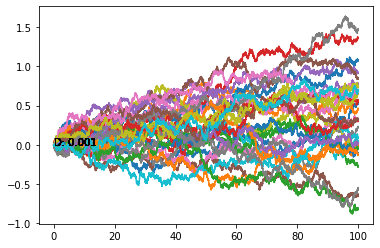

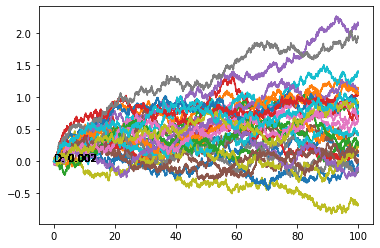

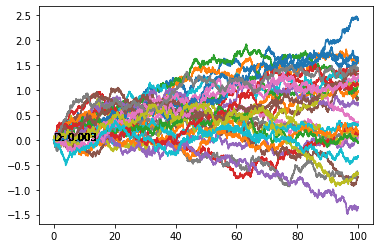

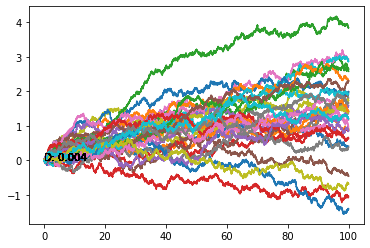

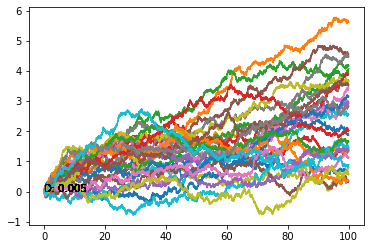

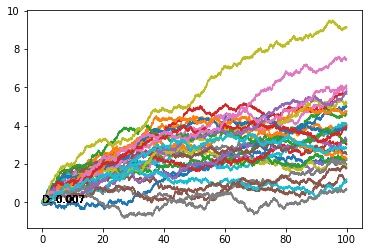

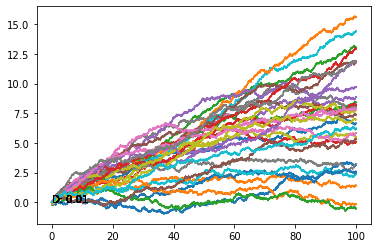

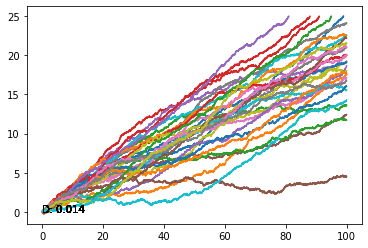

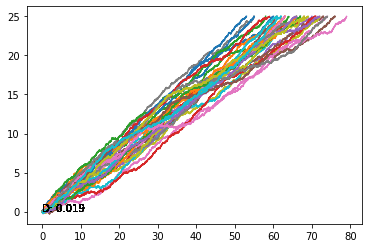

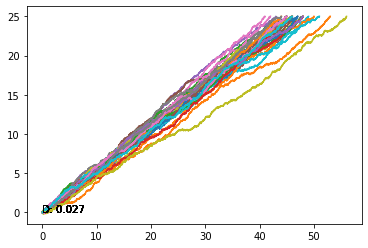

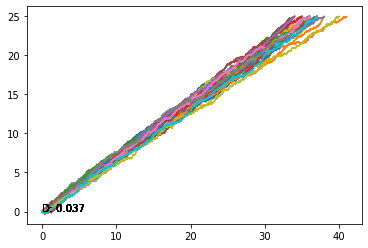

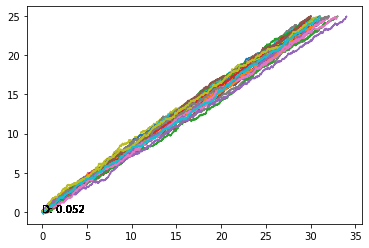

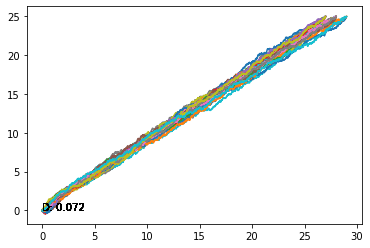

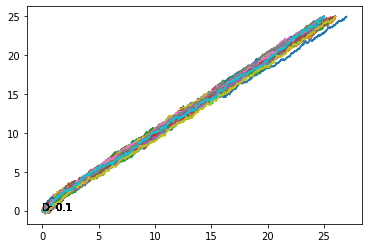

In [16]:

sol_0Db = []
for D in Ds: 
    sol_1 = []
    for run in range(run_n):
        xp = 0.0
        Ac = zeros(Nx) #initialize bound complex
        
        #intialize substrate
        As = zeros(Nx) 
        As[xs > 0.0] = linspace(0.1,length,int(Lmax/dx)) * N/2.0 # create initial gradient with slope (a0/2.0)
        As[xs > 2.0] = N # biased to the right

        # some values to save for each time step
        xp_t = [] # position
        v_t = [] # times
        burn_t = [] # burn rate
        
        noisescale = sqrt(2*dt*D) # the scale of diffusion
        t_max = int(tf/dt)
        for t in range(t_max): 
            
            total_f = D * trapz(-(xp -xs) * Ac, x=xs)
            binding = exp(-0.5 * (xp - xs) ** 2) * As
            burnt = nu * Ac
            Ac += (binding - burnt) *dt
            As += (- binding) * dt
            noise = noisescale* random.normal(0.0,1.0)
            
            xp += total_f * dt + noise # update position

            if t % 10.0 == 0.0: # save values
                xp_t.append(xp)
                v_t.append(total_f+noise/dt)
                burn_t.append(trapz(Ac*nu,x=xs))
                
    
            if abs(xp) > length -5.0: # stop before it hits an edge
                break
        
        plot(linspace(0,int((t+1)*dt),int(t/10+1)),xp_t)
        text(0.0,0.0,"D: "+str(round(D,3)))
        
        # save the mean velocity and burn rate for the run
        sol_1.append([xp_t[-2000:],burn_t[-2000:]])
    show()
    # save these for each diffusion coefficient
    sol_0Db.append(sol_1)
display.clear_output(wait=True)

### plotting just biased

[5.14234277e-03 1.60468282e-02 2.09663931e-05 1.29083849e-02
 9.59760288e-02 2.50868657e-01 3.47747917e-01 3.10142540e-01
 2.66500285e-01 2.00284160e-01 1.46191093e-01 1.07961373e-01
 7.67710013e-02]


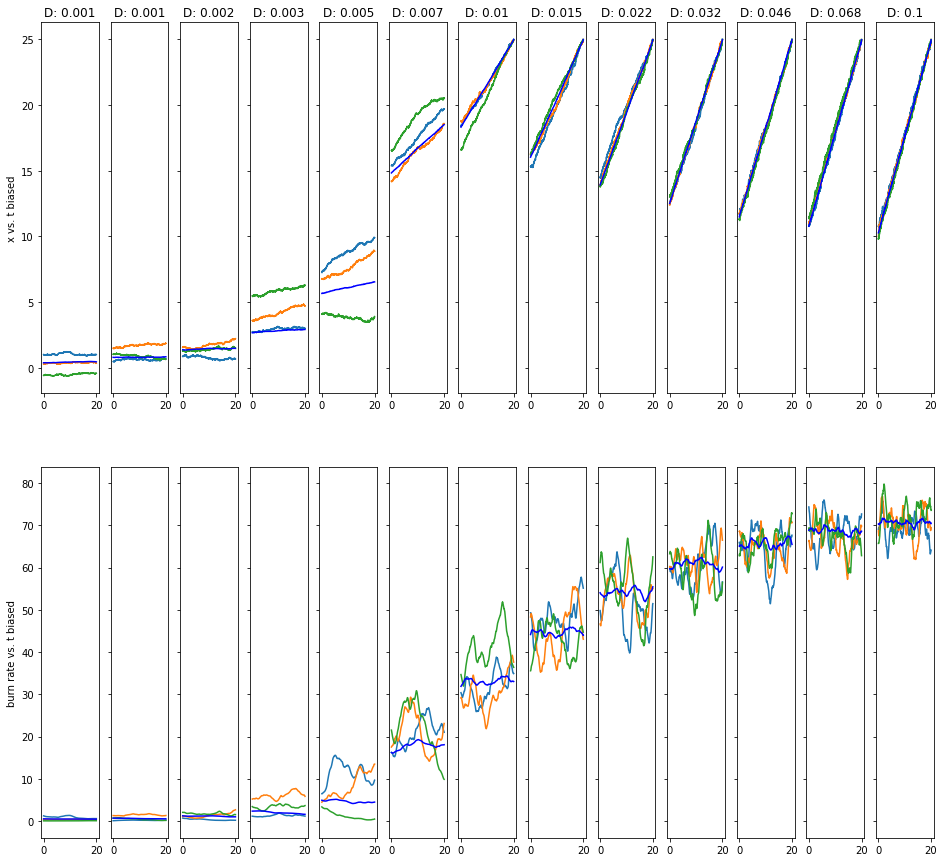

In [14]:
fig, axs = plt.subplots(2,D_n,sharey="row",figsize = (16,15))
mean_v = []
mean_burns = []
for i in range(len(sol_0Db)):
    if i ==0:
        axs[0][i].set_ylabel('x vs. t biased')
        axs[1][i].set_ylabel('burn rate vs. t biased')
    ts = []
    for j in range(len(sol_0Db[i])):
        ts.append(len(sol_0Db[i][j][0]))
    tmax = min(ts)
    tlin = linspace(0,int(tmax*dt*10.0),tmax)
    mean_xp = zeros(int(tmax))
    mean_burn = zeros(int(tmax))
    for j in range(len(sol_0Db[i])):
        xps = array(sol_0Db[i][j][0][:tmax])
        burn = array(sol_0Db[i][j][1][:tmax])
        if j % 10 ==0:
            axs[0][i].plot(tlin,xps)
            axs[1][i].plot(tlin,burn)
        mean_xp += xps/run_n
        mean_burn += burn/run_n
    axs[0][i].plot(tlin,mean_xp,"-b")
    axs[0][i].title.set_text("D: "+str(round(Ds[i],3)))
    axs[1][i].plot(tlin,mean_burn,"-b")
    mean_v.append((mean_xp[-1]-mean_xp[-int(tmax*0.5)])/(tmax*0.5*dt*10))
    mean_burns.append(mean(mean_burn[-int(tmax*0.5):],axis = 0))
        
mean_v = array(mean_v)
mean_burns = array(mean_burns)
mean_eff = 1/Ds*mean_v**2/mean_burns
print(mean_eff)
    
    

### db/dt vs. D

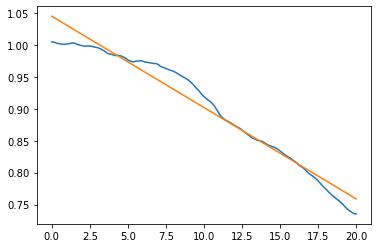

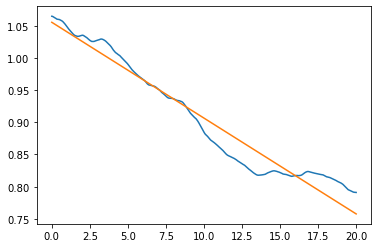

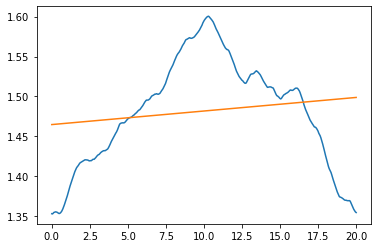

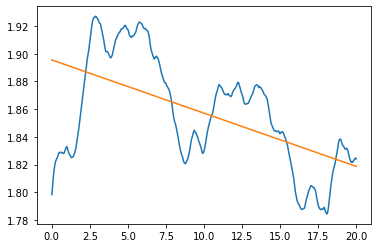

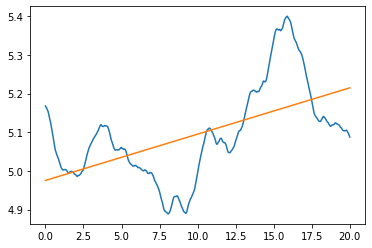

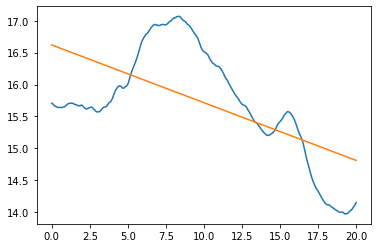

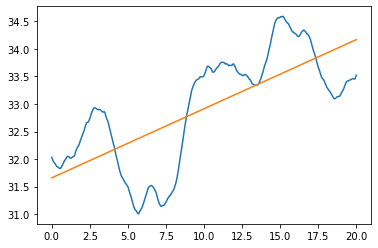

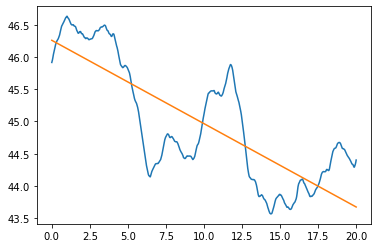

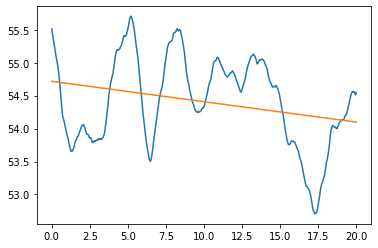

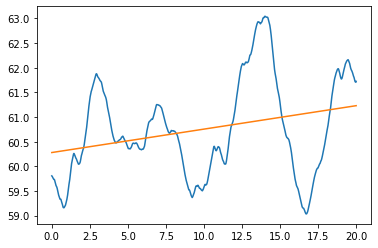

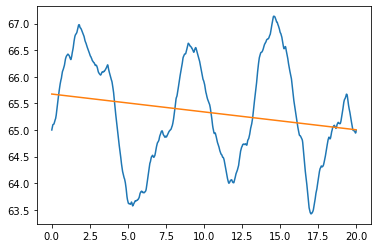

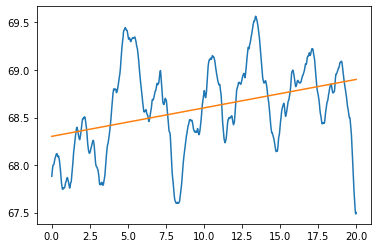

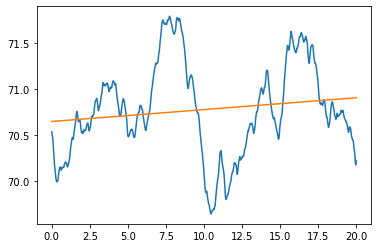

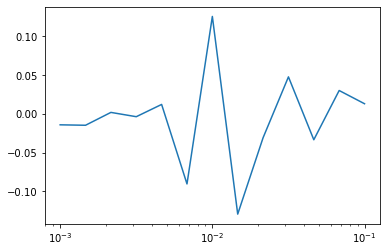

In [18]:
def linear(x,m,b):
    return m*x + b
burn_aves0 = []
for i in range(len(sol_0D)):
    burn_aves1 = []
    length =len(sol_0D[i][0][0])
    burn_mean = zeros(length)
    ts = linspace(0,int(length*10.0*dt), length)
    for j in range(len(sol_0D[i])):
        burns = array(sol_0D[i][j][1])
        
        
        poplin,popcov = curve_fit(linear,ts,burns,p0 = [0.0,0.0])
        
        #plot(ts,burns,label = "actual")
        #plot(ts,linear(ts,*poplin), label = "fit")
        
        burn_aves1.append(poplin[0])
        burn_mean += burns/run_n
    poplin,popcov = curve_fit(linear,ts,burn_mean,p0 = [0.0,0.0])
    plot(ts,burn_mean)
    plot(ts,linear(ts,*poplin))
    show()
    burn_aves0.append(mean(burn_aves1))
    
plot(Ds,burn_aves0)
xscale("log")

### diffusivity

### <x^2> vs. tau

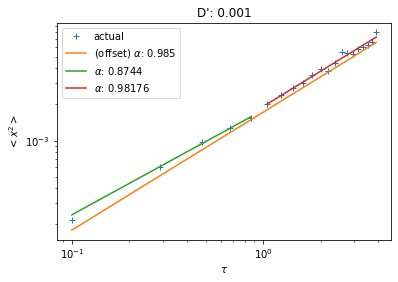

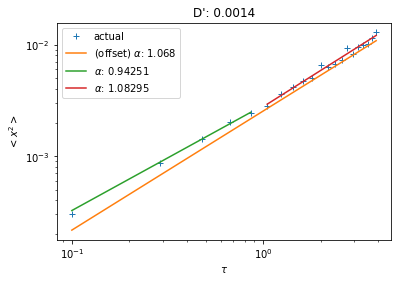

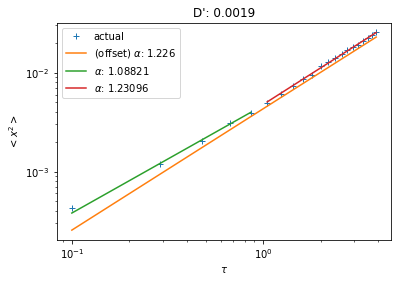

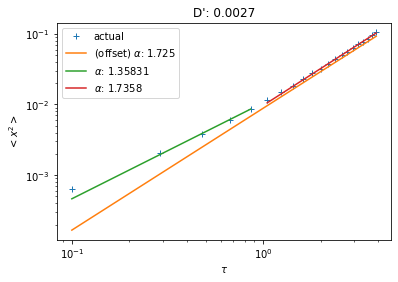

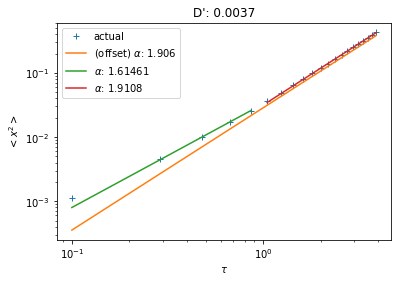

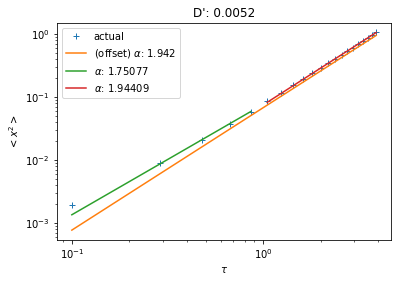

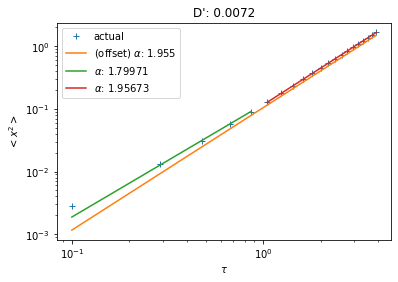

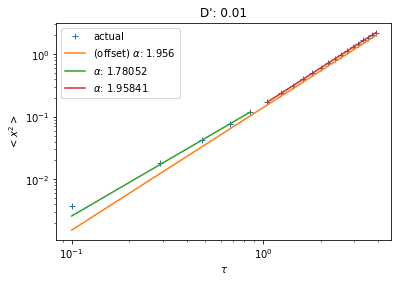

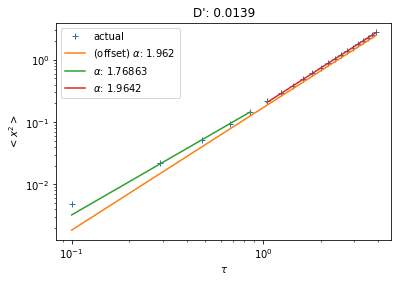

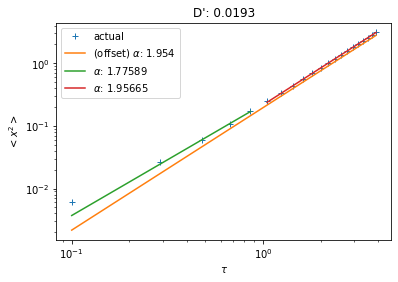

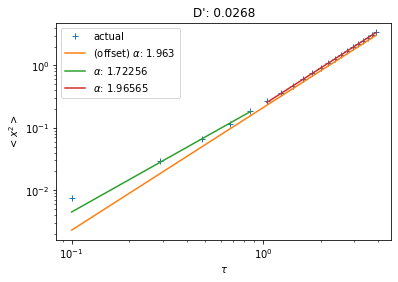

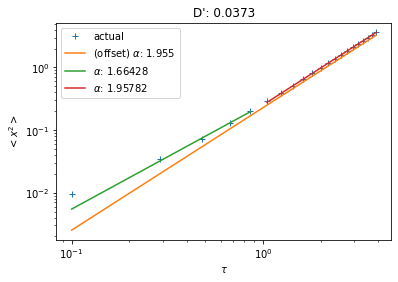

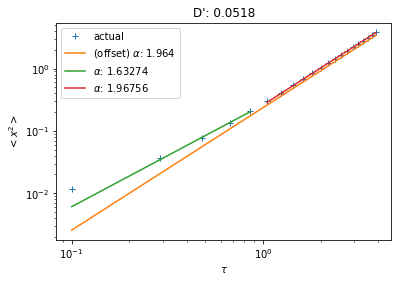

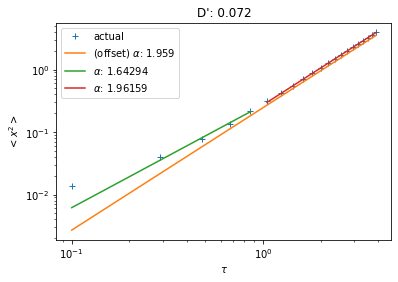

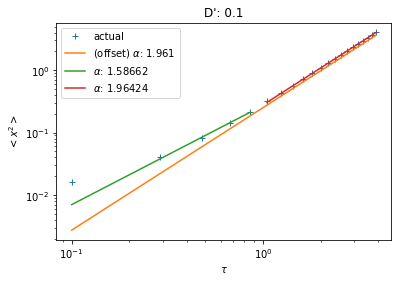

Text(0.5, 0, "D'")

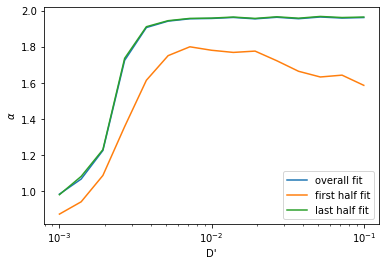

In [22]:
def alpha_exp(x,b,a):
    return b*x**a
sol = sol_0D
alphas0 = []
alphas01 = []
alphas02 = []
for i in range(D_n): # diffusion coefficients
    tmax = len(sol[i][0][0])
    taumax = tmax/5
    taus_n = 20
    taus = array(range(10,int(taumax),int((taumax-10)/taus_n)))
    x2_tau = []
    for n in taus:
        x2 = [] 
        for j in range(run_n):
            xps = array(sol[i][j][0])
            x2.extend(diff(xps[::(n+1)])**2)
        x2_tau.append(mean(x2))
    x = taus*10*dt
    y = x2_tau
    popt,popcov = curve_fit(alpha_exp,x,y,p0 = [1.0,1.0])
    
    cut = 5
    xa = x[:cut]
    ya = y[:cut]
    popt1,popcov = curve_fit(alpha_exp,xa,ya,p0 = [1.0,1.0])

    xb = x[cut:]
    yb = y[cut:]
    popt2,popcov = curve_fit(alpha_exp,xb,yb,p0 = [1.0,1.0])

    title("D': "+str(round(Ds[i],4)))
    plot(x,y,"+",label ="actual")
    plot(x,0.9*alpha_exp(x,*popt),label = r"(offset) $\alpha$: "+str(round(popt[1],3)))
    plot(xa,alpha_exp(xa,*popt1),label = r"$\alpha$: "+str(round(popt1[1],5)))
    plot(xb,alpha_exp(xb,*popt2),label = r"$\alpha$: "+str(round(popt2[1],5)))
    ylabel(r"$<x^2>$")
    xlabel(r"$\tau$")
    yscale("log")
    xscale("log")
    legend()
    show()
    alphas0.append(popt[1])
    alphas01.append(popt1[1])
    alphas02.append(popt2[1])

plot(Ds,alphas0, label = "overall fit")
plot(Ds,alphas01,label = "first half fit")
plot(Ds,alphas02,label = "last half fit")
xscale("log")
legend()
ylabel(r"$\alpha$")
xlabel("D'")
    

### Efficiency from gaussian fitting histogram delta X(tau)

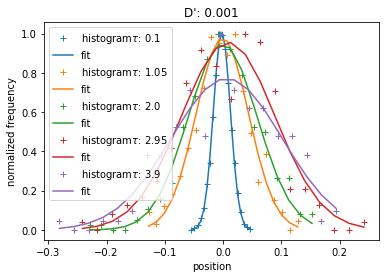

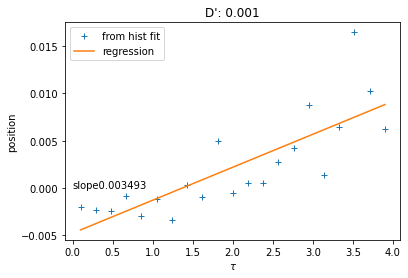

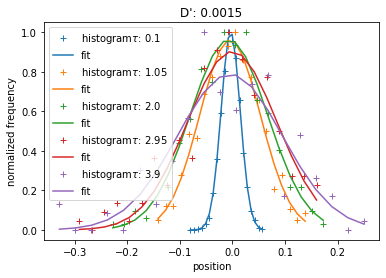

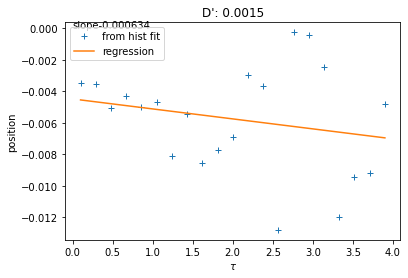

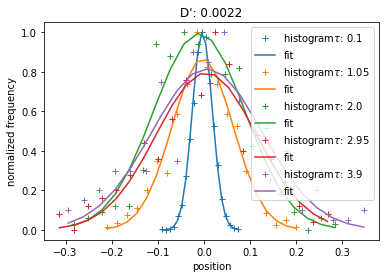

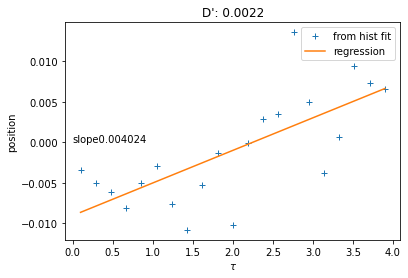

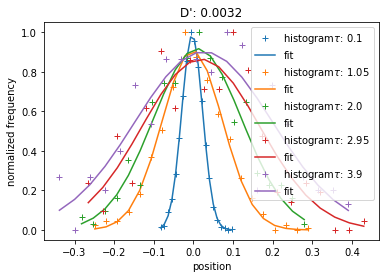

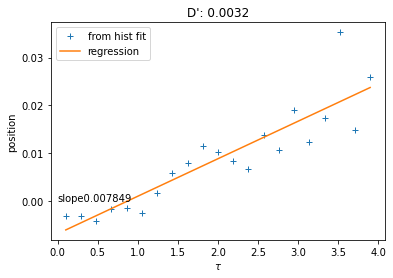

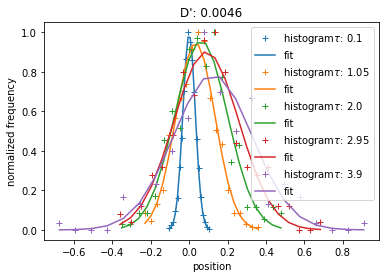

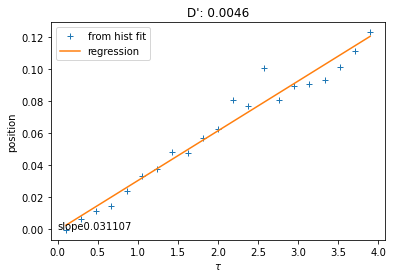

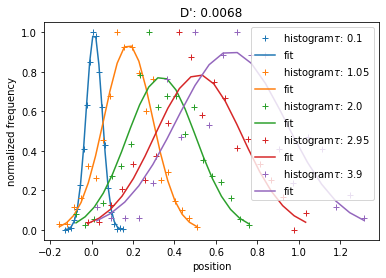

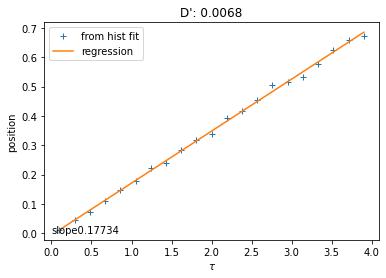

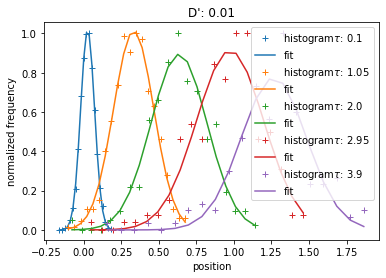

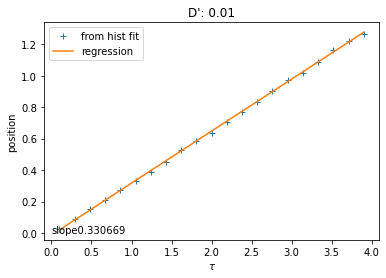

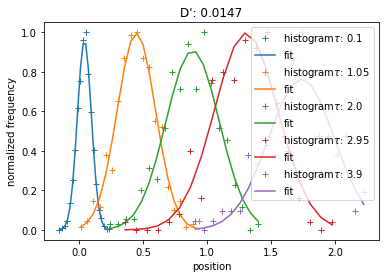

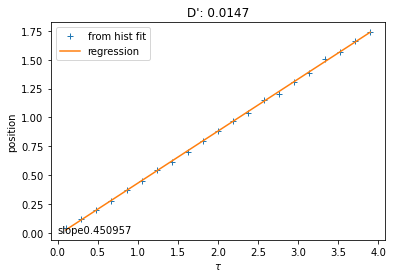

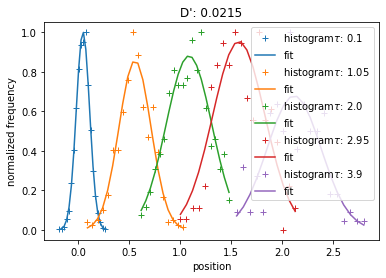

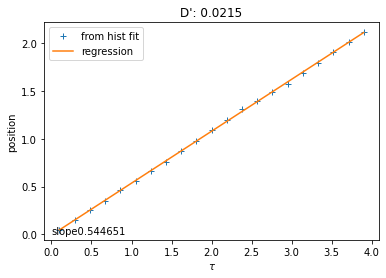

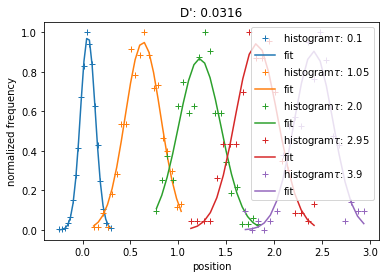

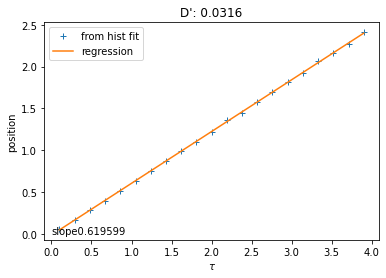

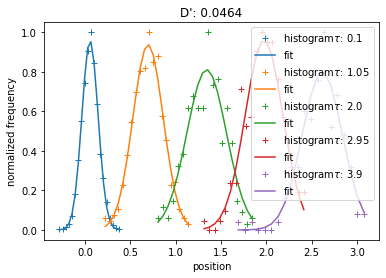

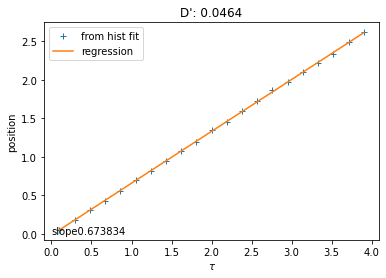

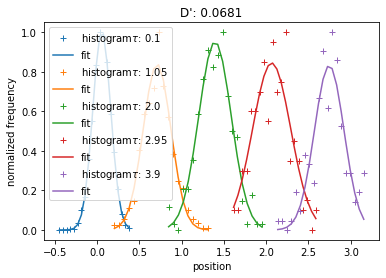

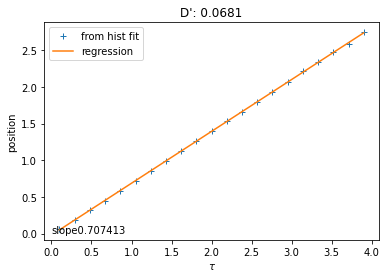

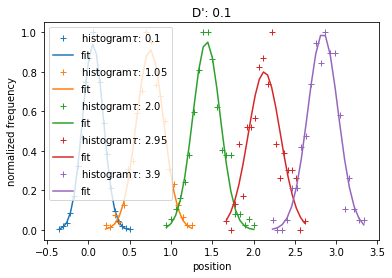

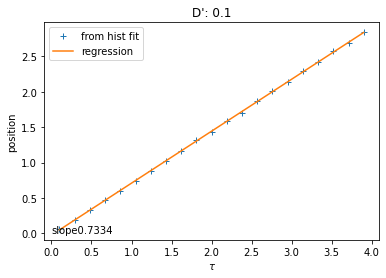

[0.001      0.0014678  0.00215443 0.00316228 0.00464159 0.00681292
 0.01       0.01467799 0.02154435 0.03162278 0.04641589 0.06812921
 0.1       ]


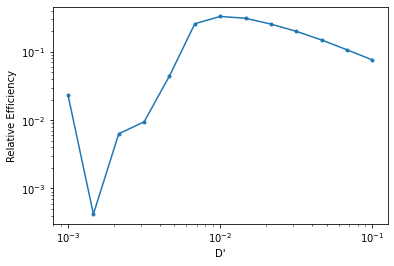

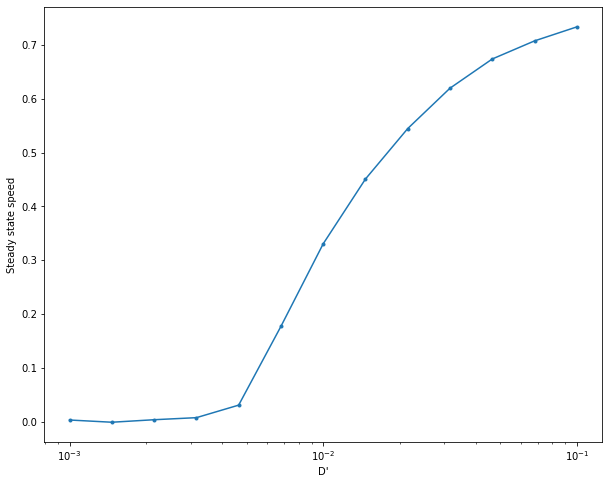

Text(0, 0.5, 'Steady burn rate')

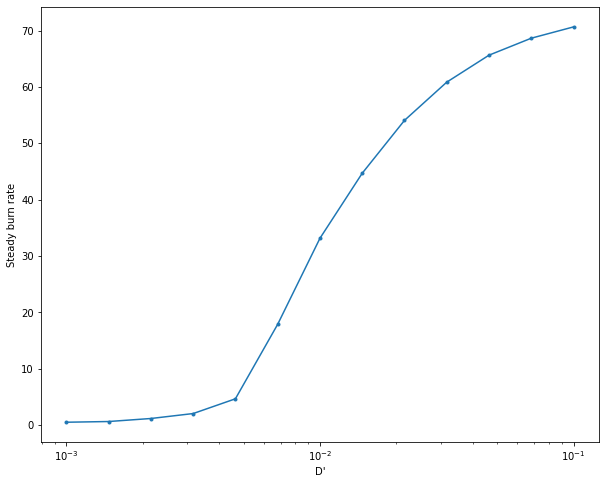

In [19]:
#fig, axs = plt.subplots(2,D_n,sharey="row",figsize = (16,15))
effs = []
vs = []
burns = []
for i in range(D_n): # diffusion coefficients
    # figure out the tmax so that each run provides the same number of taus
    burn_aves = []
    tmax = len(sol_0Db[i][j][0][0])
    taumax = tmax/5
    taus = range(10,int(taumax),int((taumax-10)/20))
    delta_xs_tau = [] # save the dxs for each tau
    for n in taus:
        delta_xs = [] # save the dxs for all runs
        for j in range(run_n):
            xps = array(sol_0Db[i][j][0])
            delta_xs.extend(diff(xps[::(n+1)]))
        delta_xs_tau.append(delta_xs)

    def gaus(x,a,ave,sigma):
        return a*numpy.exp(-(x-ave)**2/(2*sigma**2))

    def linear(x,m,b):
        return m*x + b
    colors = ["tab:blue", "tab:orange","tab:green","tab:red","tab:purple"]
    c= 0
    deltaX = []
    for k in range(len(delta_xs_tau)):
        x = histogram(delta_xs_tau[k],bins = 20)[1][:-1]
        y = histogram(delta_xs_tau[k],bins = 20)[0]

        a = max(y)
        ave = mean(x)
        sigma = mean((x-ave)**2)

        popt,pcov = curve_fit(gaus,x,y,p0=[a,ave,sigma])
        
        if k % 5 == 0:
            normalizer = max(y)
            plot(x,y/normalizer,"+",label = "histogram"+ r"$\tau$: " +str(round(taus[k]*dt*10,4)),color = colors[c])
            plot(x,gaus(x,*popt)/normalizer, label = "fit",color = colors[c])
            title("D': "+ str(round(Ds[i],4)))
            ylabel("normalized frequency")
            xlabel("position")
            legend()
            c+=1
        aveX = popt[1]
        deltaX.append(aveX)
    show()
    tausT = array(taus)*10*dt
    poplin,plin = curve_fit(linear,tausT, deltaX, p0 = [1.0,0.0])
    plot(tausT,deltaX,"+",label = "from hist fit")
    plot(tausT, linear(tausT,*poplin),label = "regression")
    text(0,0, "slope"+str(round(poplin[0],6)) )
    ylabel("position")
    xlabel(r"$\tau$")
    title("D': "+ str(round(Ds[i],4)))
    legend()
    show()
    effs.append(1/Ds[i]*poplin[0]**2/mean(burn_aves))
    vs.append(poplin[0])
    burns.append(mean(burn_aves))
plot(Ds,effs,".-")
print(Ds)
xscale("log")
yscale("log")
xlabel("D'")
ylabel("Relative Efficiency")
show()
figure(figsize = (10,8))
plot(Ds,vs,".-")
#yscale("log")
xscale("log")
xlabel("D'")
ylabel("Steady state speed")
show()
figure(figsize = (10,8))
plot(Ds,burns,".-")
#yscale("log")
xscale("log")
xlabel("D'")
ylabel("Steady burn rate")


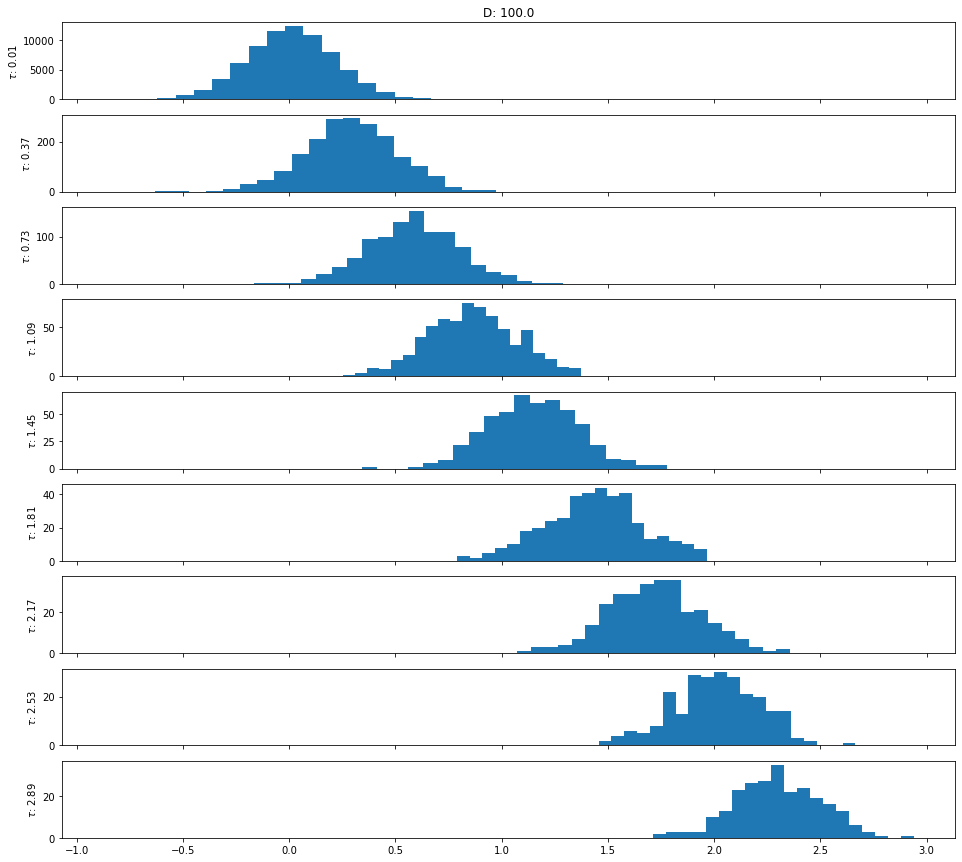

In [25]:
fig, axs = plt.subplots(len(delta_xs_tau),1,sharex="col",figsize = (16,15))
ct = 0
axs[0].title.set_text("D: "+str(round(Ds[-1],3)))
for i in range(len(delta_xs_tau)):
    axs[ct].hist(delta_xs_tau[i],bins = 20)
    axs[ct].set_ylabel(r"$\tau$: " + str(round((taus[i]+1)*10*dt,3)))
    
    ct += 1

### Efficiency with quadratic fit

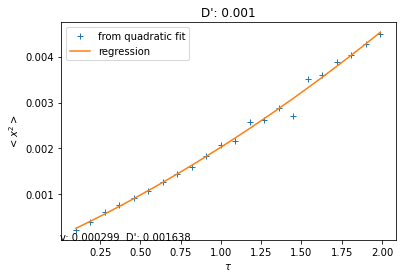

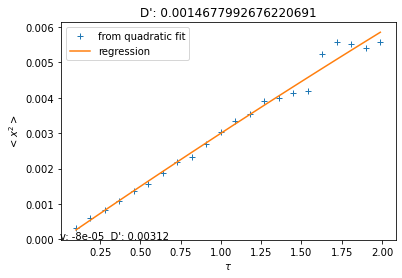

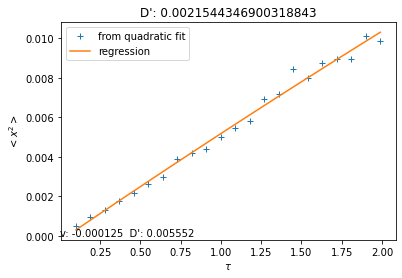

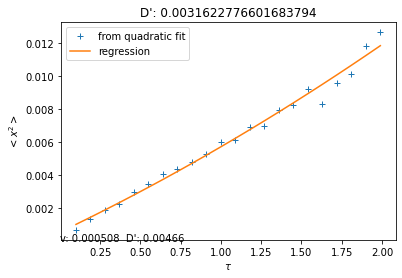

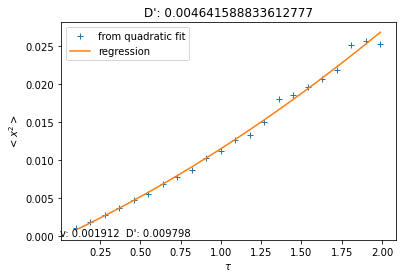

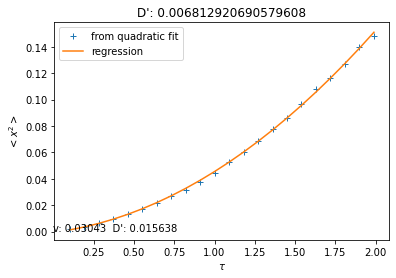

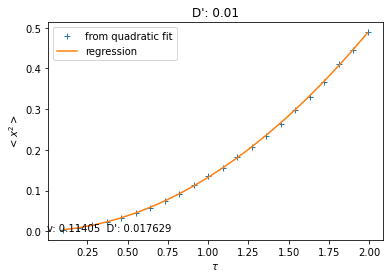

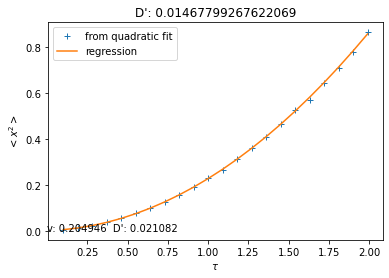

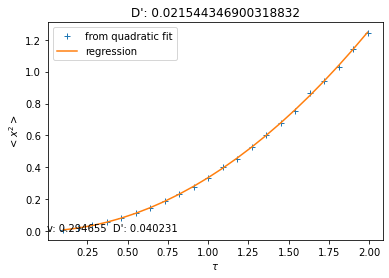

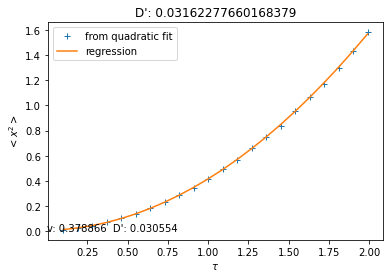

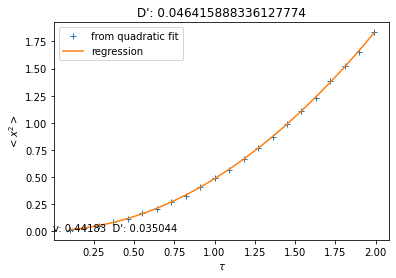

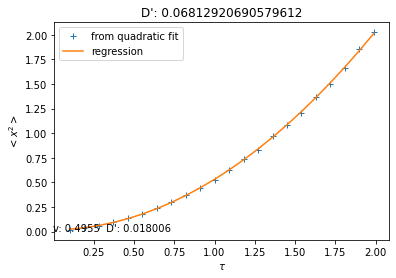

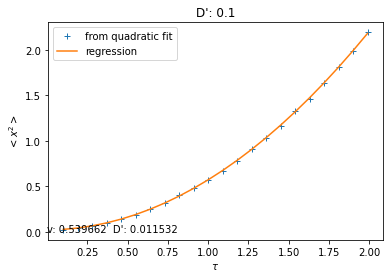

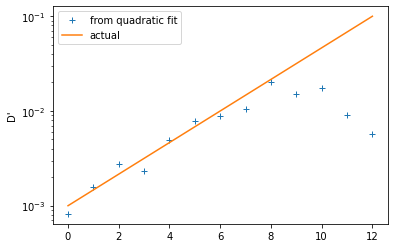

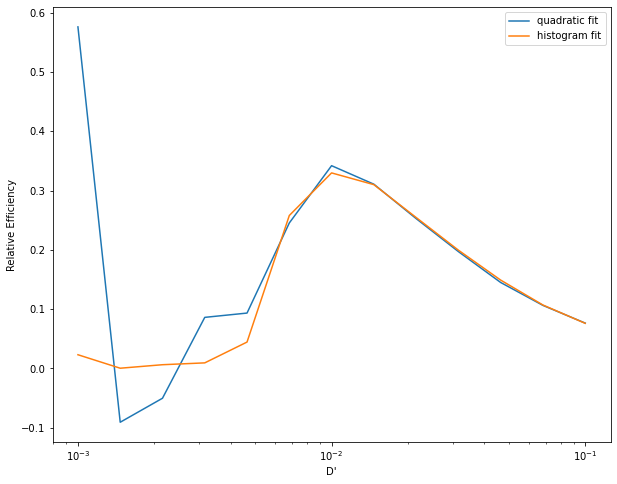

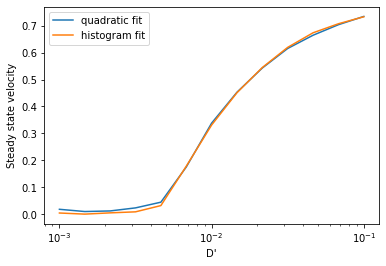

In [16]:
def quadratic(x,a,b,c):
    return a*x**2 + b*x + c

effs2 = []
vs2 = []
diffusions = []
for i in range(D_n): # diffusion coefficients
    # figure out the tmax so that each run provides the same number of taus
    ts = []
    burn_aves = []
    for j in range(len(sol_0Db[i])): # runs
        ts.append(len(sol_0Db[i][j][0]))
        burn_aves.append(mean(array(sol_0Db[i][j][1][-int(tmax*0.5):]),axis=0))
    tmax = min(ts)
    taumax = tmax*0.5/5
    taus = array(range(10,int(taumax),int((taumax-10)/20)))
    x2_tau = []
    for n in taus:
        x2 = [] 
        for j in range(len(sol_0Db[i])):
            xps = array(sol_0Db[i][j][0][-int(tmax*0.5):])
            x2.extend(diff(xps[::(n+1)])**2)
        x2_tau.append(mean(x2))
    x = taus*10*dt
    y = x2_tau
    popt,pcov = curve_fit(quadratic,x,y,p0=[1,1,1])
    
    title("D': "+str(Ds[i]))
    plot(x,y,"+",label ="from quadratic fit")
    plot(x,quadratic(x,*popt),label = "regression")
    text(0,0,"v: "+str(round(popt[0],6))+ "  D': "+str(round(popt[1],6)))
    ylabel(r"$<x^2>$")
    xlabel(r"$\tau$")
    legend()
    show()
    eff = 1/Ds[i]*popt[0]/mean(burn_aves)
    effs2.append(eff)
    vs2.append(sqrt(abs(popt[0])))
    diffusions.append(popt[1]/2)
    
plot(range(len(Ds)),diffusions,"+",label = "from quadratic fit")
plot(range(len(Ds)),Ds,label = "actual")
yscale("log")
ylabel("D'")
legend()
show()


figure(figsize=(10, 8))
plot(Ds,array(effs2),label = "quadratic fit")
plot(Ds,effs, label = "histogram fit")
xscale("log")
#yscale("log")
xlabel("D'")
ylabel("Relative Efficiency")
legend()
show()
plot(Ds,vs2,label = "quadratic fit")
plot(Ds,vs,label = "histogram fit")
xlabel("D'")
ylabel("Steady state velocity")
xscale("log")
#yscale("log")
legend()


### diffusivity

### end point and linear fit

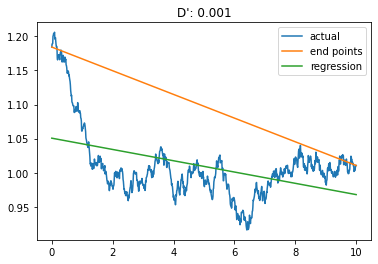

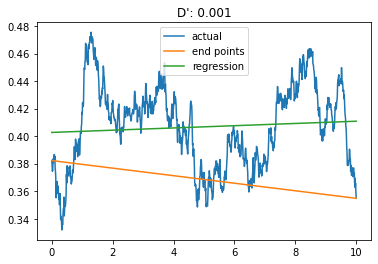

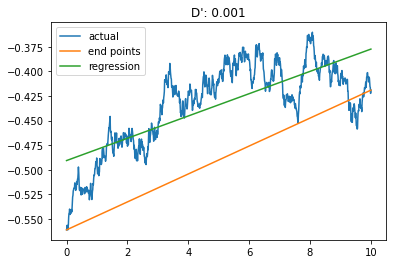

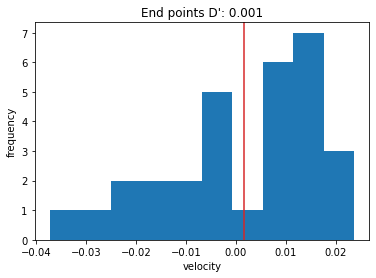

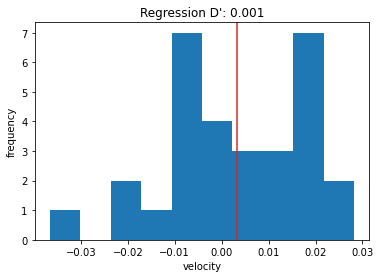

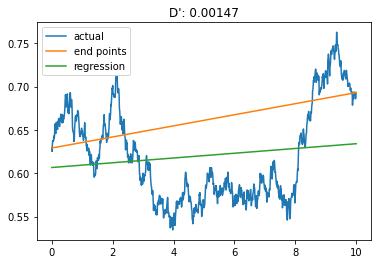

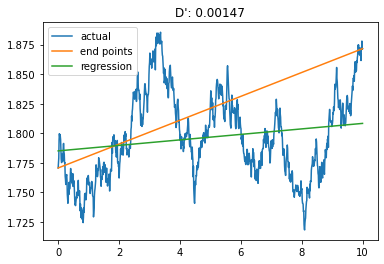

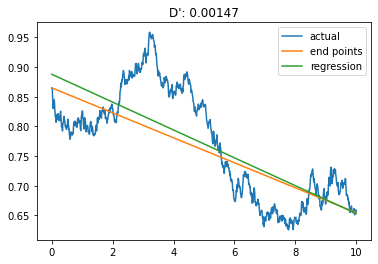

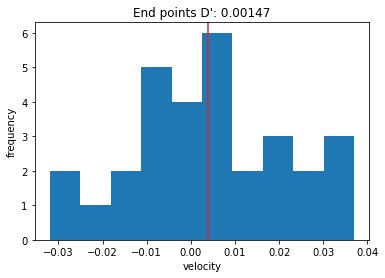

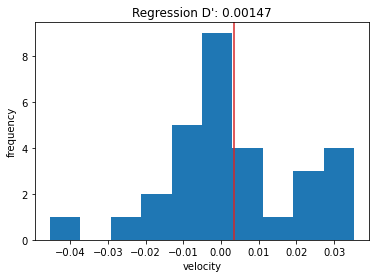

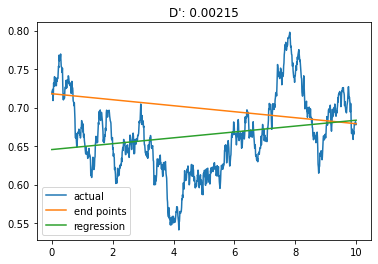

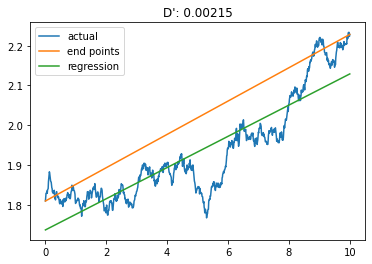

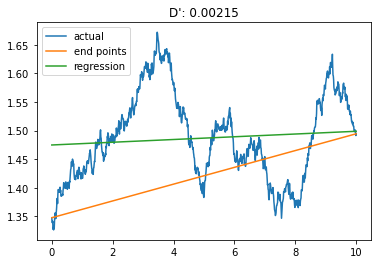

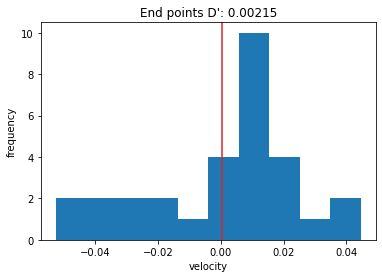

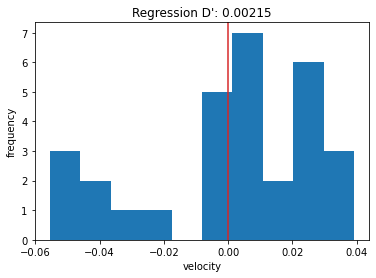

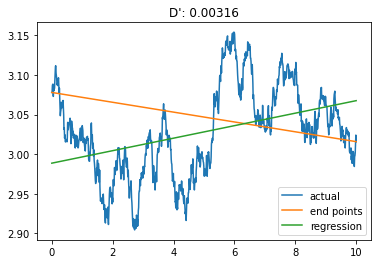

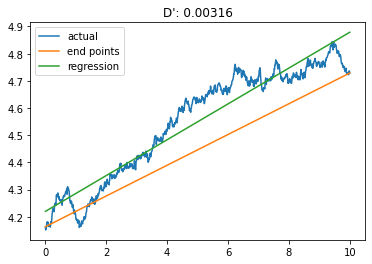

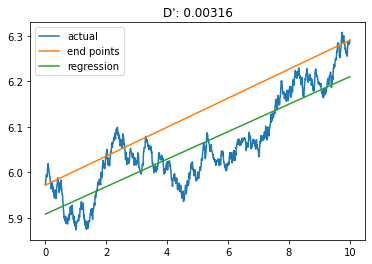

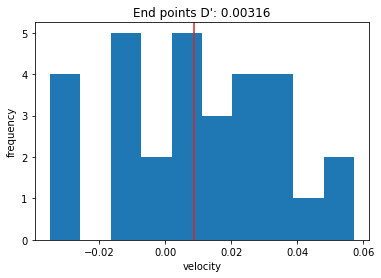

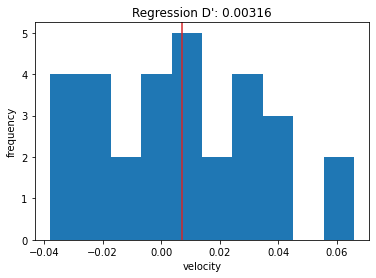

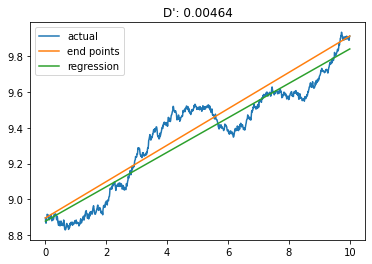

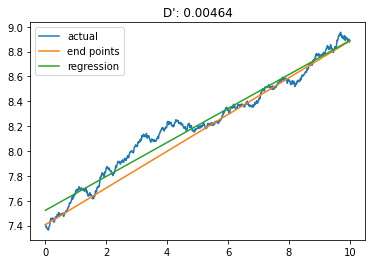

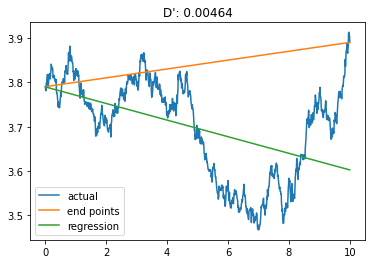

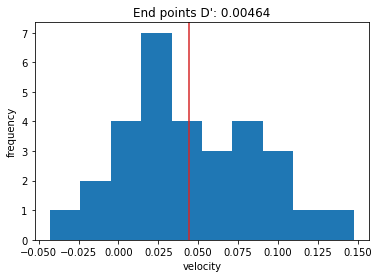

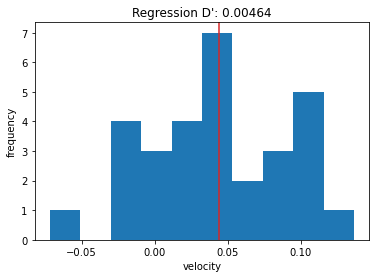

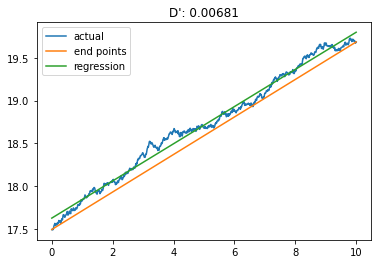

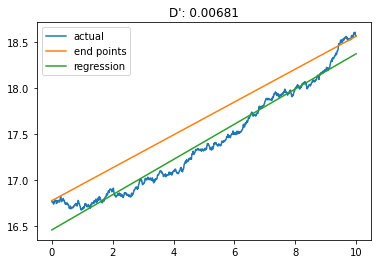

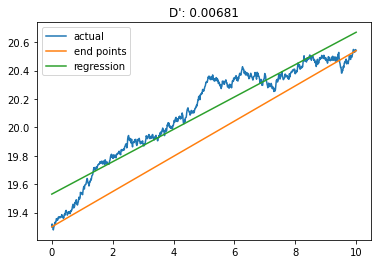

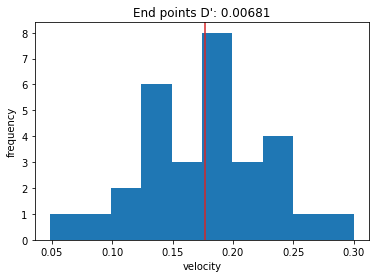

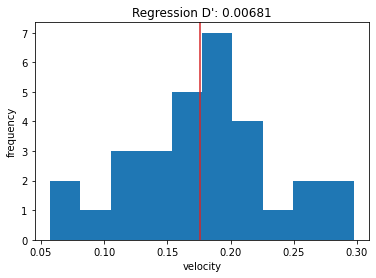

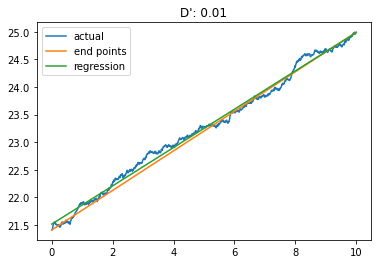

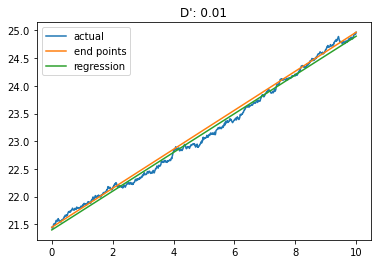

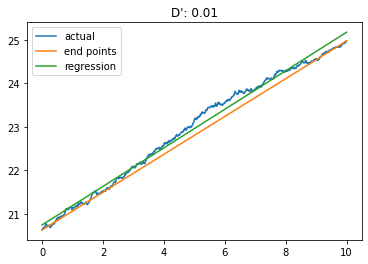

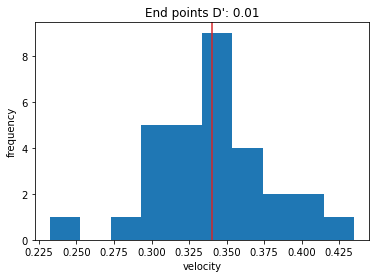

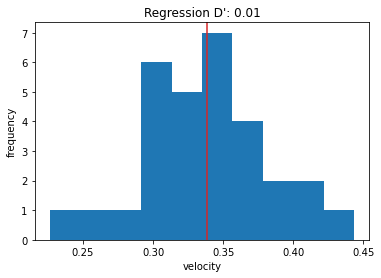

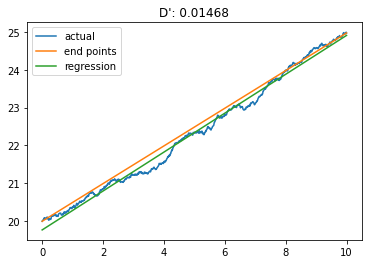

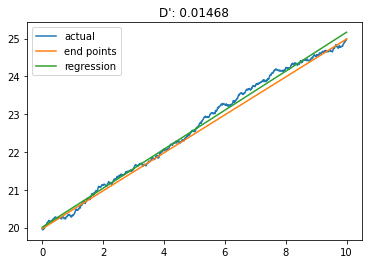

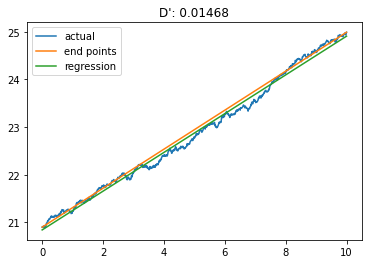

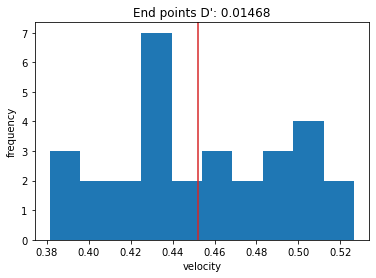

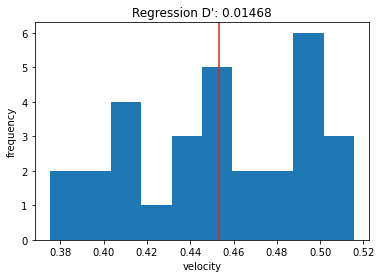

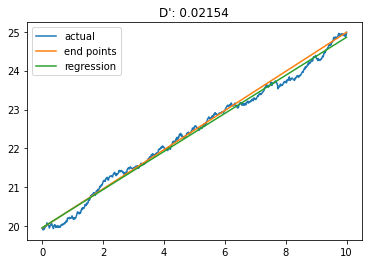

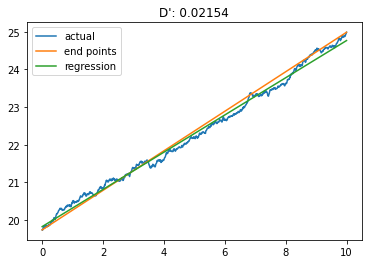

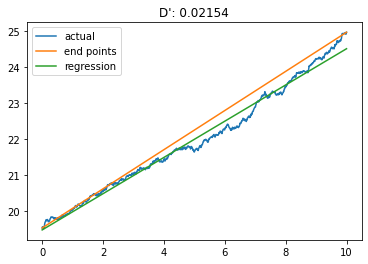

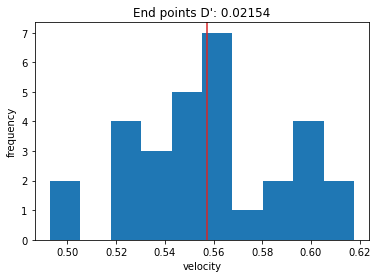

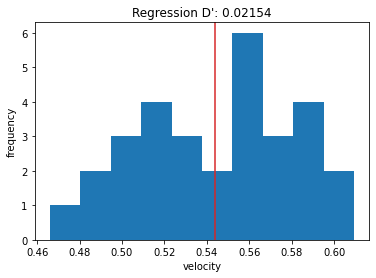

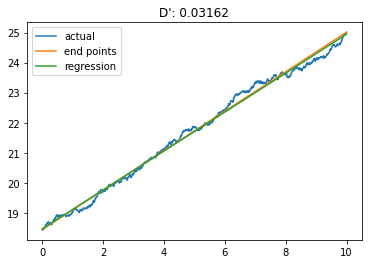

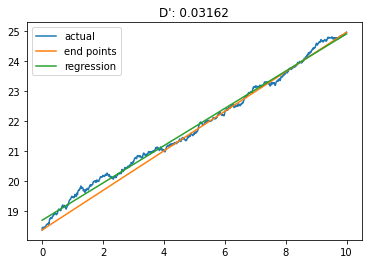

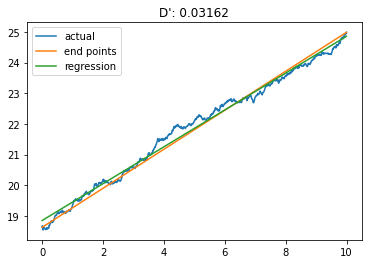

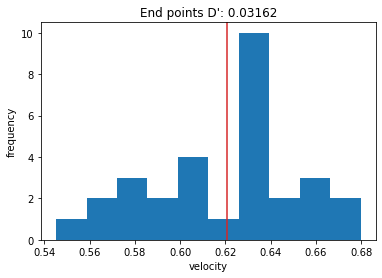

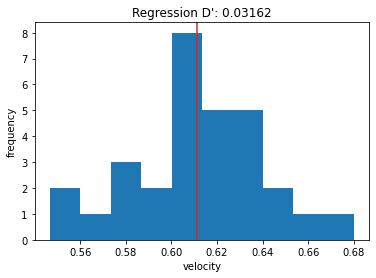

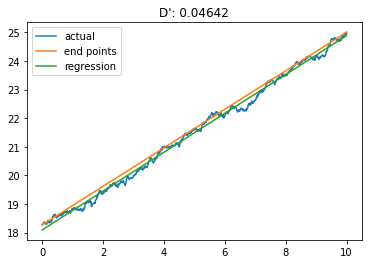

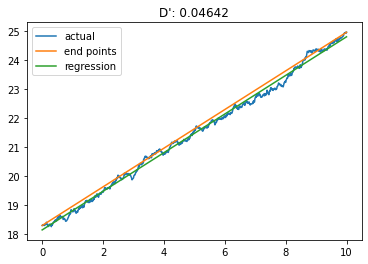

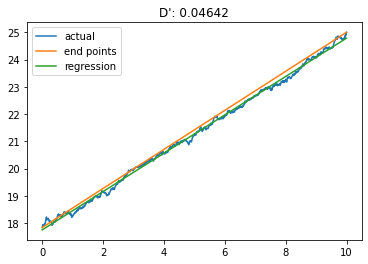

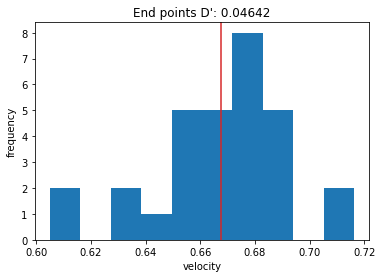

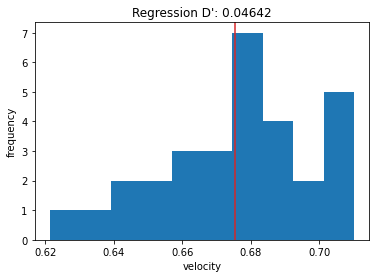

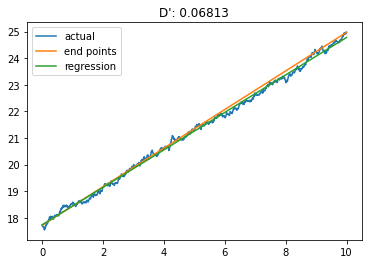

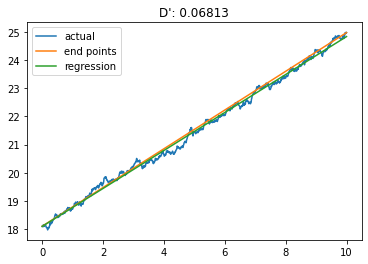

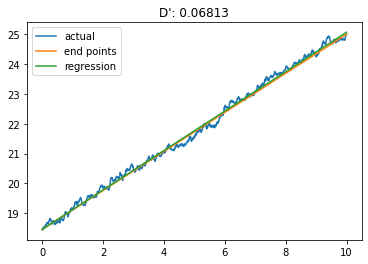

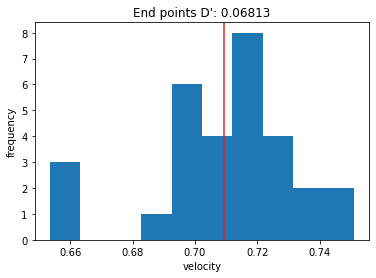

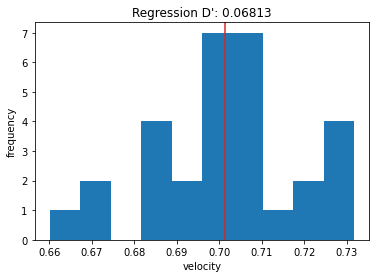

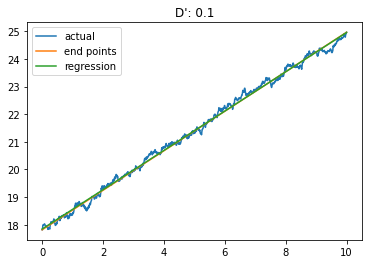

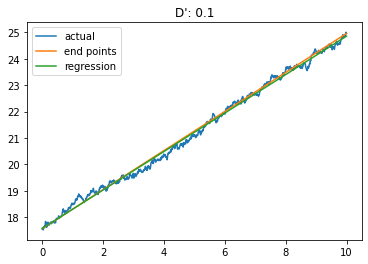

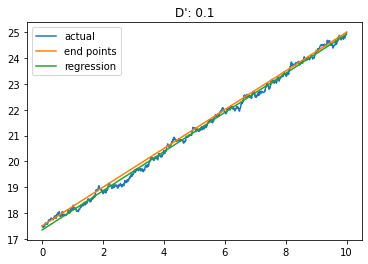

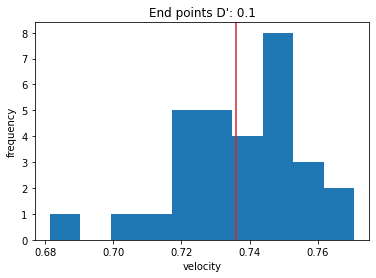

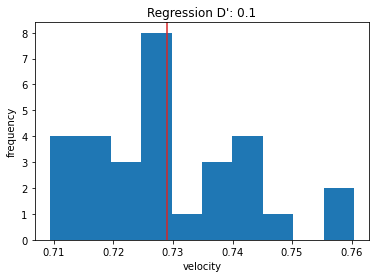

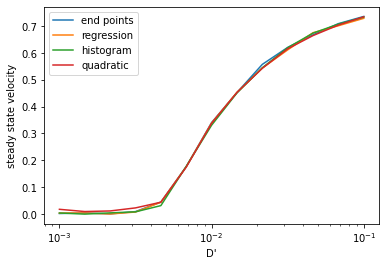

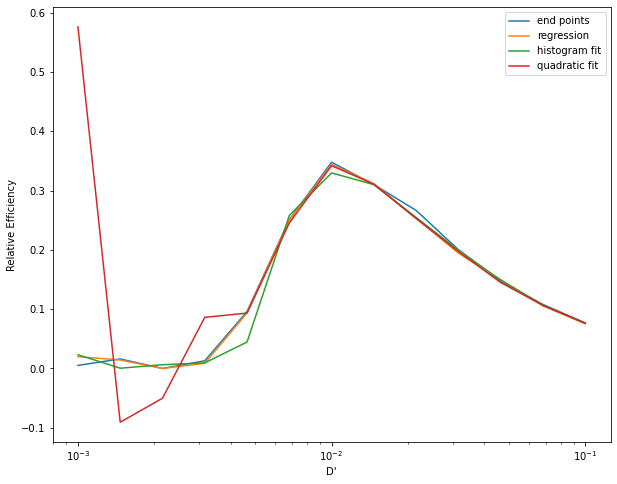

In [17]:
vep = []
vlin = []
effep = []
efflin = []
for i in range(D_n): # diffusion coefficients
    burn_aves = []
    vs_tmp = []
    vs_tmp2 = []
    for j in range(len(sol_0Db[i])):
        xps = array(sol_0Db[i][j][0][-int(tmax*0.5):])
        burn_aves.append(mean(array(sol_0Db[i][j][1][-int(tmax*0.5):]),axis=0))
        te = len(xps)*dt*10
        ts = linspace(0,te,len(xps))
        v = (xps[-1]-xps[0])/te
        poplin,plin = curve_fit(linear,ts, xps, p0 = [1.0,0.0])
        vs_tmp.append(v)
        vs_tmp2.append(poplin[0])
        if j % 10 == 0:
            plot(ts,xps, label = "actual")
            plot(ts,v*ts+xps[0], label = "end points")
            plot(ts,linear(ts,*poplin),label = "regression")
            title("D': " +str(round(Ds[i],5)))
            legend()
            show()
    hist(vs_tmp)
    title("End points D': " +str(round(Ds[i],5)))
    axvline(mean(vs_tmp),c = "tab:red")
    xlabel("velocity")
    ylabel("frequency")
    show()
    hist(vs_tmp2)
    title("Regression D': " +str(round(Ds[i],5)))
    axvline(mean(vs_tmp2),c = "tab:red")
    xlabel("velocity")
    ylabel("frequency")
    show()
    vep.append(mean(vs_tmp))
    vlin.append(mean(vs_tmp2))
    effep.append(1/Ds[i]*mean(vs_tmp)**2/mean(burn_aves))
    efflin.append(1/Ds[i]*mean(vs_tmp2)**2/mean(burn_aves))
plot(Ds,vep, label ="end points")
plot(Ds,vlin, label ="regression")
plot(Ds,vs, label = "histogram")
plot(Ds,vs2,label = "quadratic")
xlabel("D'")
ylabel("steady state velocity")
#yscale("log")
xscale("log")
legend()

figure(figsize=(10, 8))
plot(Ds,effep, label = "end points")
plot(Ds,efflin, label = "regression")
plot(Ds,effs, label = "histogram fit")
plot(Ds,array(effs2),label = "quadratic fit")
xscale("log")
#yscale("log")
xlabel("D'")
ylabel("Relative Efficiency")
legend()
show()